# Nucleotide substitution models
## Parameter estimation and tree inference

## 1. Modèle Jukes & Cantor

Graphe __DAG__ du modèle: <br/>
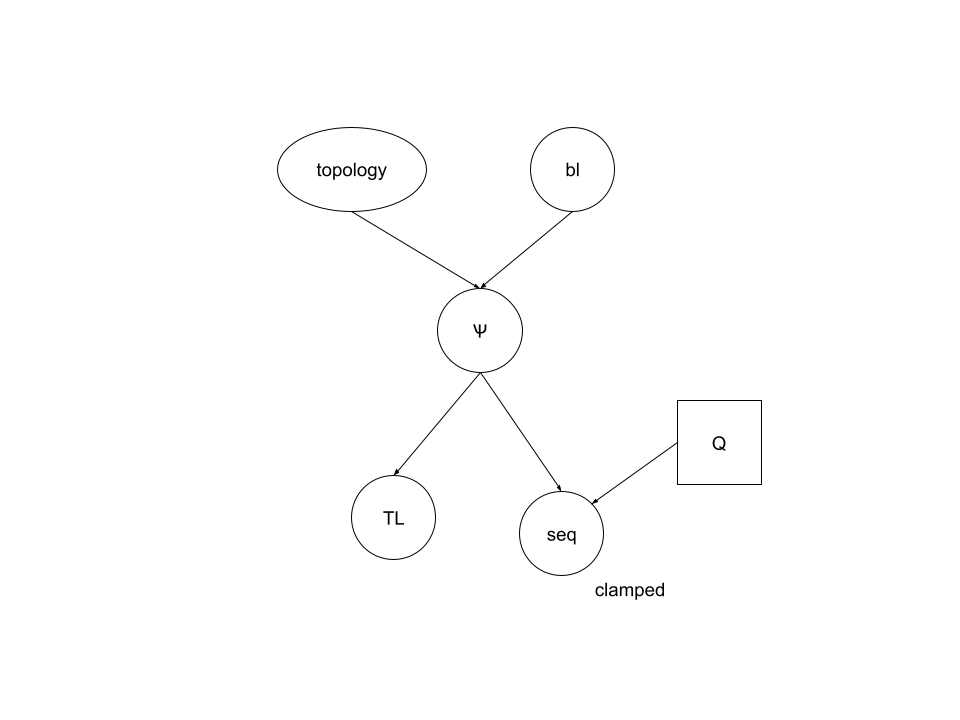

Le nombre d'espèces est determiné en utilisant la fonction _ntaxa()_, elle permet de trouver le nombre d'espèces directement à partir des données. Ensuite on calcule le nombre de branches comme suit: <br/>
<center>$nb_{branchs} = 2 \times N_{species} - 3$</center>

<br/>

_Sorex_ est l'outgroup choisi qui est utilisé ici pour enraciner l'arbre.
1. Exploration de toutes les topologies (équi-probables), _topology_ est donc une variable aléatoire qui assumera toutes les topologies possibles de l'arbre.
2. On associe la longueur de chaque branche (_bl_) à une variable aléatoire sur laquelle on met un à priori pour en pouvoir estimer la valeur: 
```
 bl[i] ~ dnExponential(10.0) # longueur moyenne de 0.1
```
Il pourrait être un prior assez penalisant pour les branches longues, car on s'attend d'avoir une longueur moyenne de $0.1$.
<br/>

3. $\psi$ arbre phylogénétique (sortie du modèle?)
4. $TL$ somme totale des longueur des branches
5. $Q$ matrice de  substition des acides nucléiques (selon le modèle de *Jukes & Cantor*)
6. On fixe la variable $seq$ sur les valeurs effectivement observées sur les données

Probabilité à posteriori:
<center>
$P(topology, bl | seq=data)$
</center>

Dans la variable $moves$ on stocke les types de mouvements qu'on veut faire sur les différentes variable pour pouvoir explorer les topologies. Ici on utilise les mouvements: <br/>
- NNI
- SPR
- scale (différent pour chaque branche)

<br/>

En sortie:
- _.log_ monitor général <br/>
- _.tree_ monitor spécial pour les topologies explorées

In [2]:
data <- readDiscreteCharacterData("../TP3/placBRCA1short.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 3
taxa <- data.taxa()

out_group = clade("Sorex")

# tree topology
topology ~ dnUniformTopology(taxa, outgroup = out_group) 
for (i in 1:n_branches) {
 bl[i] ~ dnExponential(10.0)
}
psi := treeAssembly(topology, bl)

# total tree length (just for monitoring)
TL := sum(bl)

# JC substitution process
Q <- fnJC(4)
seq ~ dnPhyloCTMC( tree=psi, Q=Q, type="DNA" ) 
seq.clamp( data )

my_model = model(psi)

# moves
moves = VectorMoves()
moves.append(mvNNI(topology, weight=3.0))
moves.append(mvSPR(topology, weight=3.0))
for (i in 1:n_branches) {
   moves.append(mvScale(bl[i], weight=1.0))
}

monitors[1] = mnModel(filename="../TP3/analyses/BRCA1_JC.log", printgen=10, separator = TAB)
monitors[2] = mnFile(psi,filename="../TP3/analyses/BRCA1_JC.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, TL)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

# Post-analysis: constructing the maximum a posteriori tree
treetrace = readTreeTrace("../TP3/analyses/BRCA1_JC.trees", treetype="non-clock", burnin=0.1)
map_tree = mapTree(treetrace, "../TP3/analyses/BRCA1_JC_map.tree")



   Successfully read one character matrix from file '../TP3/placBRCA1short.nex'
   Error:	Variable "topology" cannot be used with more than one treeAssembly function.
   
   Running MCMC simulation
   This simulation runs 1 independent replicate.
   The simulator uses 127 different moves in a random move schedule with 131 moves per iteration
   

Iter        |      Posterior   |     Likelihood   |          Prior   |             TL   |    elapsed   |        ETA   |
-----------------------------------------------------------------------------------------------------------------------
0           |       -19320.2   |       -19245.9   |       -74.2383   |       12.96703   |   00:00:00   |   --:--:--   |
100         |       -13791.2   |       -13790.6   |      -0.619641   |        5.60516   |   00:00:08   |   --:--:--   |
200         |       -12875.4   |       -12880.7   |        5.29542   |       5.013654   |   00:00:16   |   00:13:04   |
300         |       -12334.4   |       -12341.2   |

5900        |       -11661.2   |         -11671   |        9.76115   |       4.567081   |   00:07:06   |   00:04:56   |


Iter        |      Posterior   |     Likelihood   |          Prior   |             TL   |    elapsed   |        ETA   |
-----------------------------------------------------------------------------------------------------------------------
6000        |       -11659.4   |       -11671.2   |        11.8093   |       4.362266   |   00:07:13   |   00:04:48   |
6100        |       -11673.3   |       -11684.4   |        11.1892   |       4.424273   |   00:07:20   |   00:04:41   |
6200        |       -11654.3   |       -11667.4   |        13.1135   |       4.231844   |   00:07:27   |   00:04:33   |
6300        |       -11656.2   |       -11668.2   |        12.0527   |        4.33793   |   00:07:38   |   00:04:28   |
6400        |       -11659.8   |       -11670.1   |        10.2893   |       4.514265   |   00:07:47   |   00:04:22   |
6500        |       -11647.9   |      

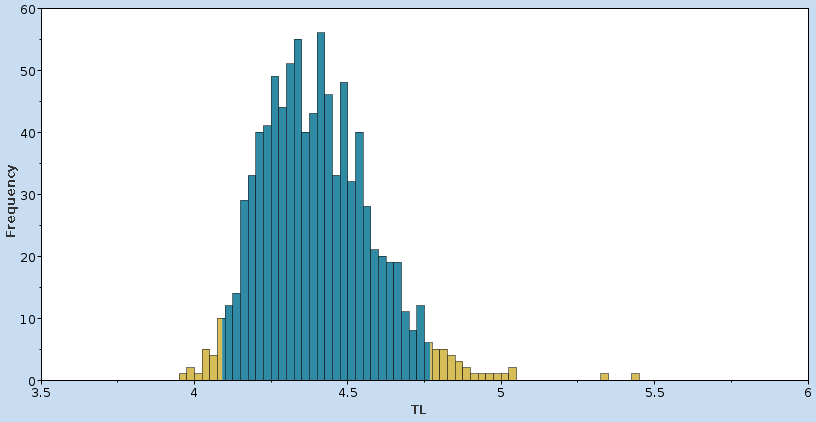

On explorant les traces à partir du fichier _.log_ , on s'aperçoit que pour une position donnée on a en moyenne $4.4$ substitutions.

On remarque depuis la trace que la phase de chauffe est assez longue, du coup on choisi de considerer un nombre d'itérations supérieur pour cette phase de chauffe en modifiant le paramètre _burnin_ :

In [3]:
# Post-analysis: constructing the maximum a posteriori tree
treetrace = readTreeTrace("../TP3/analyses/BRCA1_JC.trees", treetype="non-clock", burnin=0.3)
map_tree = mapTree(treetrace, "../TP3/analyses/BRCA1_JC_map(1).tree")

   Processing file "/home/tommaso/M2/Semestre_3/Phylo/repo_git/../TP3/analyses/BRCA1_JC.trees"

Progress:
0---------------25---------------50---------------75--------------100
********************************************************************

   Compiling maximum a posteriori tree from 701 trees.
   
   Summarizing clades ...
   

Progress:
0---------------25---------------50---------------75--------------100
********************************************************************

   Annotating tree ...


## 2. Modèle Tamura 92

Le modèle _Tamura 91_ est reconductible à un modèle *Jukes & Cantor* pour des valeurs $\kappa = 1$ et $\gamma = \frac{1}{2}$ à un facteur multiplicatif près. Pour ces valeurs de $\kappa$ et de $\gamma$ les transversions et les transitions ont donc la même probabilité. Graphe __DAG__ pour ce modèle:
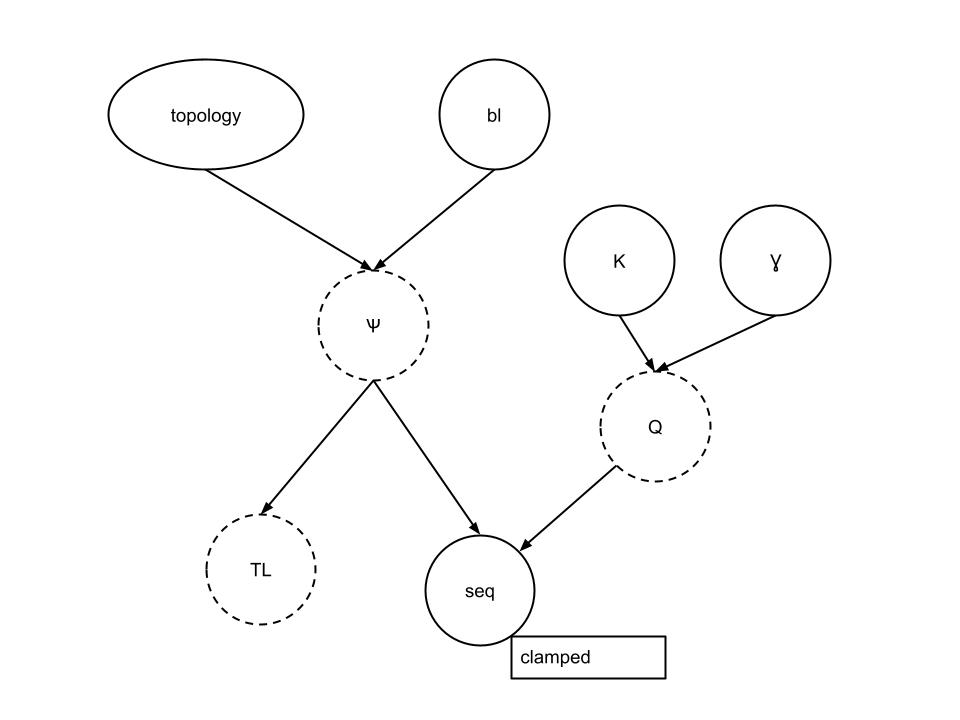

In [5]:
data <- readDiscreteCharacterData("../TP3/placBRCA1short.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 3
taxa <- data.taxa()

out_group = clade("Sorex")

# tree topology
topology ~ dnUniformTopology(taxa, outgroup = out_group) 
for (i in 1:n_branches) {
 bl[i] ~ dnExponential(10.0)
}
psi := treeAssembly(topology, bl)

# total tree length (just for monitoring)
TL := sum(bl)

# transition-transversion rate ratio
kappa ~ dnExponential(lambda = 0.1)

# gamma
gamma ~ dnBeta(1.0, 1.0)

# T92 substitution process
Q := fnT92(kappa = kappa, gc = gamma)
seq ~ dnPhyloCTMC(tree=psi, Q=Q, type="DNA")
seq.clamp( data )

my_model = model(psi)

# moves
moves = VectorMoves()
moves.append(mvNNI(topology, weight=3.0))
moves.append(mvSPR(topology, weight=3.0))
moves.append(mvSlide(gamma, weight=1.0))
moves.append(mvScale(kappa, weight=1.0))
for (i in 1:n_branches) {
   moves.append(mvScale(bl[i], weight=1.0))
}

monitors[1] = mnModel(filename="../TP3/analyses/BRCA1_short_T91.log", printgen=10, separator = TAB)
monitors[2] = mnFile(psi,filename="../TP3/analyses/BRCA1_short_T91.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, TL)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

# Post-analysis: constructing the maximum a posteriori tree
treetrace = readTreeTrace("../TP3/analyses/BRCA1_short_T91.trees", treetype="non-clock", burnin=0.1)
map_tree = mapTree(treetrace, "../TP3/analyses/BRCA1_short_T91_map.tree")



   Successfully read one character matrix from file '../TP3/placBRCA1third.nex'
   Error:	Variable "topology" cannot be used with more than one treeAssembly function.
   
   Running MCMC simulation
   This simulation runs 1 independent replicate.
   The simulator uses 129 different moves in a random move schedule with 133 moves per iteration
   

Iter        |      Posterior   |     Likelihood   |          Prior   |             TL   |    elapsed   |        ETA   |
-----------------------------------------------------------------------------------------------------------------------
0           |       -58914.8   |       -58833.9   |       -80.8984   |       13.33184   |   00:00:00   |   --:--:--   |
100         |         -25052   |       -25026.4   |       -25.5756   |       7.825394   |   00:00:21   |   --:--:--   |
200         |       -23014.3   |         -22997   |       -17.2235   |       6.986825   |   00:00:40   |   00:32:40   |
300         |       -22187.9   |       -22173.2   |

Si on considère le paramètre $\kappa$ et sa trace, on peut noter que la phase de chauffe est pratiquement suffisant pour le modèle __T91__. Sa mediane est estimée à $4.426$ qui est compris dans l'intervalle de credibilité $[4.0501; 4.865]$. <br/>
On aboutit à la même conclusion pour le tracé de $\gamma$. Sa mediane est estimée à $0.4475$ avec un intervalle de credibilité $[0.4594; 0.4985]$.

__ESS__: c'est le nombre d'échantillons qu'on peut considèrer comme indepéndants, si sur _tracer_ cette valeur est en rouge ou orange, ca veut dire qu'il y a une forte auto-corrélation et qu'il faudrait donc augmenter le nombre d'itérations.

## Tamura 91 sur la troisième position des codons

Les troisièmes positions des codons sont beaucoup moins impliquées dans les processus évolutifs en raison de leur neutralité. Pour cela elles sont beaucoup plus informatives du processus de mutation des séquences.

In [5]:
data <- readDiscreteCharacterData("../TP3/placBRCA1third.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 3
taxa <- data.taxa()

out_group = clade("Sorex")

# tree topology
topology ~ dnUniformTopology(taxa, outgroup = out_group) 
for (i in 1:n_branches) {
 bl[i] ~ dnExponential(10.0)
}
psi := treeAssembly(topology, bl)

# total tree length (just for monitoring)
TL := sum(bl)

# transition-transversion rate ratio
kappa ~ dnExponential(lambda = 0.1)

# gamma
gamma ~ dnBeta(1.0, 1.0)

# T92 substitution process
Q := fnT92(kappa = kappa, gc = gamma)
seq ~ dnPhyloCTMC(tree=psi, Q=Q, type="DNA")
seq.clamp( data )

my_model = model(psi)

# moves
moves = VectorMoves()
moves.append(mvNNI(topology, weight=3.0))
moves.append(mvSPR(topology, weight=3.0))
moves.append(mvSlide(gamma, weight=1.0))
moves.append(mvScale(kappa, weight=1.0))
for (i in 1:n_branches) {
   moves.append(mvScale(bl[i], weight=1.0))
}

monitors[1] = mnModel(filename="../TP3/analyses/BRCA1_third_T91.log", printgen=10, separator = TAB)
monitors[2] = mnFile(psi,filename="../TP3/analyses/BRCA1_third_T91.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, TL)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

# Post-analysis: constructing the maximum a posteriori tree
treetrace = readTreeTrace("../TP3/analyses/BRCA1_third_T91.trees", treetype="non-clock", burnin=0.1)
map_tree = mapTree(treetrace, "../TP3/analyses/BRCA1_third_T91_map.tree")



   Successfully read one character matrix from file '../TP3/placBRCA1third.nex'
   Error:	Variable "topology" cannot be used with more than one treeAssembly function.
   
   Running MCMC simulation
   This simulation runs 1 independent replicate.
   The simulator uses 129 different moves in a random move schedule with 133 moves per iteration
   

Iter        |      Posterior   |     Likelihood   |          Prior   |             TL   |    elapsed   |        ETA   |
-----------------------------------------------------------------------------------------------------------------------
0           |       -58914.8   |       -58833.9   |       -80.8984   |       13.33184   |   00:00:00   |   --:--:--   |
100         |         -25052   |       -25026.4   |       -25.5756   |       7.825394   |   00:00:21   |   --:--:--   |
200         |       -23014.3   |         -22997   |       -17.2235   |       6.986825   |   00:00:40   |   00:32:40   |
300         |       -22187.9   |       -22173.2   |

## 3. Modèle Hasegawa, Kishino, Yano (HKY)

In [1]:
# revoir code
data <- readDiscreteCharacterData("../TP3/placBRCA1short.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 3
taxa <- data.taxa()

out_group = clade("Sorex")

# tree topology
topology ~ dnUniformTopology(taxa, outgroup = out_group) 
for (i in 1:n_branches) {
 bl[i] ~ dnExponential(10.0)
}
psi := treeAssembly(topology, bl)

# total tree length (just for monitoring)
TL := sum(bl)

# pi
pi ~ dnDirichlet([1.0, 1.0, 1.0, 1.0])

# kappa
kappa ~ dnexponential(lambda = 0.1)

# HKY substitution process
Q := fnHKY(kappa=kappa, baseFrequencies=pi)
seq ~ dnPhyloCTMC(tree=psi, Q=Q, type="DNA")
seq.clamp( data )

my_model = model(psi)

# moves
moves = VectorMoves()
moves.append(mvNNI(topology, weight=3.0))
moves.append(mvSPR(topology, weight=3.0))
moves.append(mvScale(kappa, weight=1.0))
moves.append(mvDirichletSimplex(pi, weight=1.0, alpha=10))
for (i in 1:n_branches) {
   moves.append(mvScale(bl[i], weight=1.0))
}

monitors[1] = mnModel(filename="../TP3/analyses/BRCA1_third_HKY.log", printgen=10, separator = TAB)
monitors[2] = mnFile(psi,filename="../TP3/analyses/BRCA1_third_HKY.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, TL)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

# Post-analysis: constructing the maximum a posteriori tree
treetrace = readTreeTrace("../TP3/analyses/BRCA1_third_HKY.trees", treetype="non-clock", burnin=0.1)
map_tree = mapTree(treetrace, "../TP3/analyses/BRCA1_third_HKY_map.tree")



   Missing Variable:	Variable os does not exist

   Successfully read one character matrix from file '../TP3/placBRCA1short.nex'
   Error:	No function named 'dnexponential'
   Missing Variable:	Variable kappa does not exist
   Missing Variable:	Variable Q does not exist
   Missing Variable:	Variable seq does not exist
   Missing Variable:	Variable kappa does not exist
   Error:	Cannot find node with name 'pi' in the model but received a move working on it.
   Missing Variable:	Variable analysis does not exist
   Error:	Could not find filename: BRCA1_third_HKY.trees
   Could not read file named "BRCA1_third_HKY.trees" in directory named "/home/tommaso/M2/Semestre_3/Phylo/repo_git/../TP3/analyses" because the file does not
   exist
   Missing Variable:	Variable treetrace does not exist


Le modèle _HKY_ ne porte pas beaucoup plus d'information par rapport au modèle _T91_. Les processus mutationnels ne sont pas forcement equi-distribués sur les deux brins comme on peut le voir ici. Cela arrive principalement quand il y a la traduction couplé à la transcription.